In [1]:
!pip install -q gdown

Running on CPU
Attempting to download from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS
To: /content/user-transactions.json
100%|██████████| 91.2M/91.2M [00:00<00:00, 281MB/s]


✅ Successfully loaded 100000 wallet records from Google Drive
Sample wallet data: {'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}
🔄 Preprocessing transaction data...
✅ Processed 3497 unique wallets from 100000 transactions
🔄 Extracting features from wallet data...
✅ Extracted features for 34

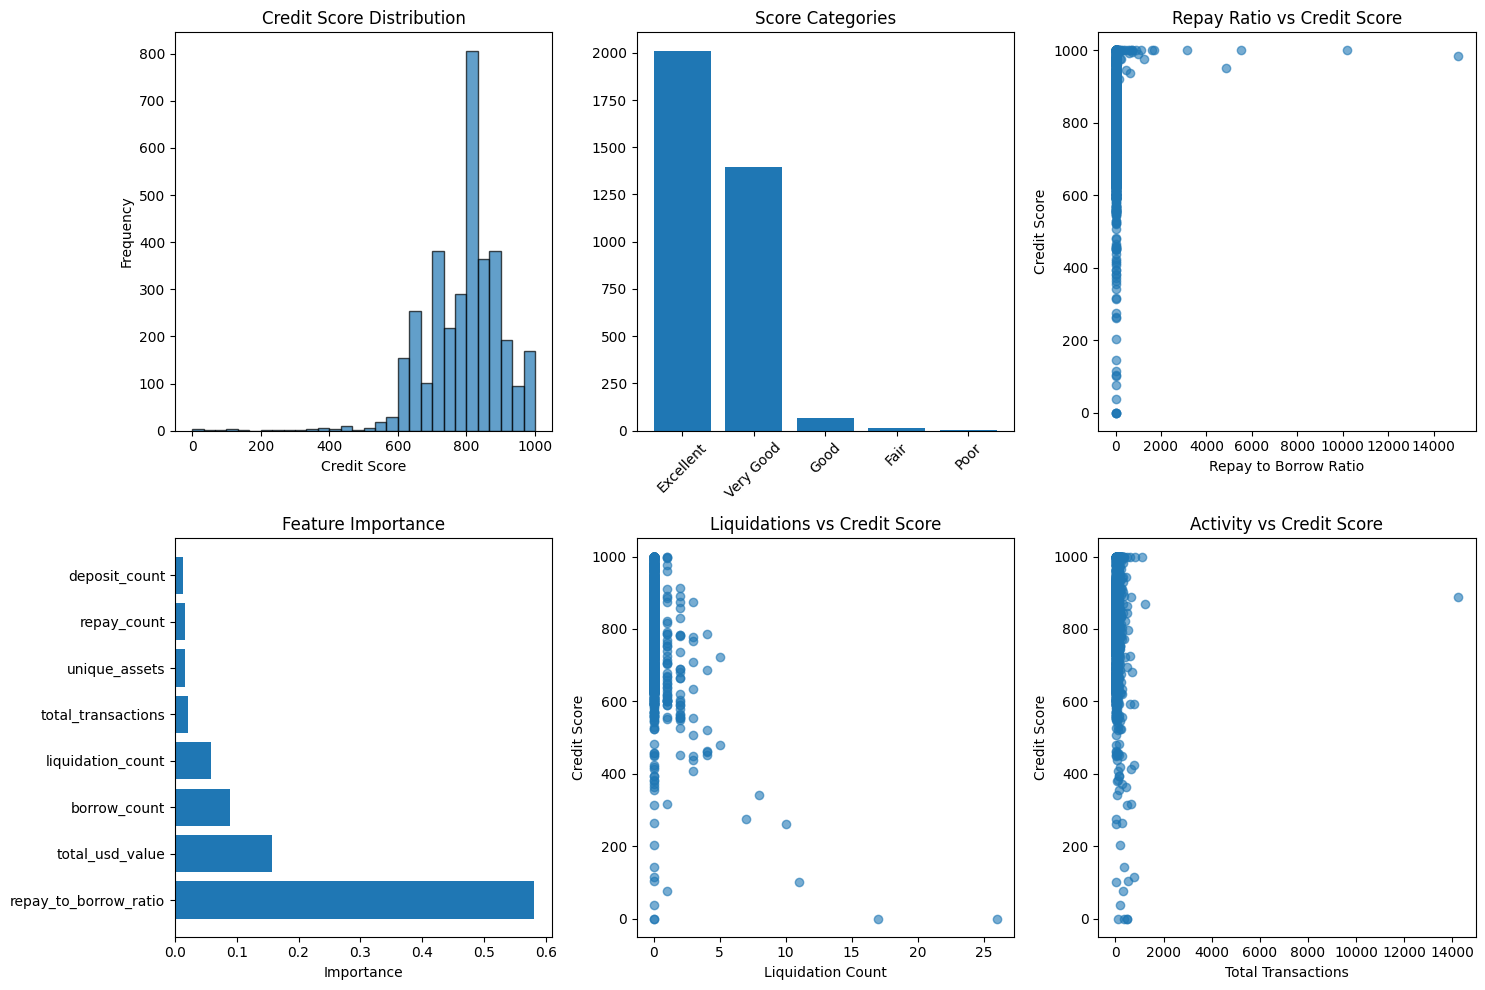


📊 AAVE CREDIT SCORING SUMMARY
📋 Dataset Overview:
   Total Wallets: 3,497
   Average Credit Score: 795.52
   Median Credit Score: 827.26
   Standard Deviation: 111.08

🎯 Score Distribution:
   Poor: 6 wallets (0.2%)
   Fair: 14 wallets (0.4%)
   Good: 69 wallets (2.0%)
   Very Good: 1,396 wallets (39.9%)
   Excellent: 2,008 wallets (57.4%)

⚠️  Risk Indicators:
   Wallets with Liquidations: 101 (2.9%)
   Average Score (with liquidations): 642.16
   Low Repay Ratio (<0.5): 757 (21.6%)

🏆 Top Performing Wallets:
   0x000bc61d... Score: 1000
   0x0030d58f... Score: 1000
   0x0051e6e6... Score: 1000
   0x005c7aa4... Score: 1000
   0x0062cb1c... Score: 1000

✅ Analysis Complete! Check the generated files:
   📄 wallet_scores.csv - Individual wallet scores
   📄 feature_importance.csv - ML model feature rankings
   📊 comprehensive_analysis.png - Visualization charts


In [2]:
# AAVE Credit Scoring - Google Colab Compatible Notebook
# Author: Your Name

# ---------------------------
# 📌 STEP 1: Setup & Imports
# ---------------------------

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Try to import gdown, install if not available
try:
    import gdown
    GDOWN_AVAILABLE = True
except ImportError:
    print("gdown not available. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "gdown"])
    import gdown
    GDOWN_AVAILABLE = True

# GPU check (optional)
try:
    import tensorflow as tf
    print("GPU Available:" if tf.config.list_physical_devices('GPU') else "Running on CPU")
except ImportError:
    print("TensorFlow not available - using CPU")

# ---------------------------
# 📁 STEP 2: Data Loading Options
# ---------------------------

def load_data():
    """Load data from various sources"""

    # Option 1: Try to download from Google Drive
    try:
        print("Attempting to download from Google Drive...")
        gdown.download('https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS',
                      'user-transactions.json', quiet=False)

        with open("user-transactions.json", "r") as f:
            data = json.load(f)
        print(f"✅ Successfully loaded {len(data)} wallet records from Google Drive")
        return data

    except Exception as e:
        print(f"❌ Failed to download from Google Drive: {e}")

        # Option 2: Check if file exists locally
        try:
            with open("user-transactions.json", "r") as f:
                data = json.load(f)
            print(f"✅ Successfully loaded {len(data)} wallet records from local file")
            return data
        except FileNotFoundError:
            print("❌ Local file not found")

            # Option 3: Generate synthetic data for demonstration
            print("🔄 Generating synthetic data for demonstration...")
            return generate_synthetic_data()

def generate_synthetic_data(num_wallets=1000):
    """Generate synthetic AAVE transaction data"""

    np.random.seed(42)
    synthetic_data = []

    actions = ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']

    for i in range(num_wallets):
        wallet = f"0x{''.join(np.random.choice('0123456789abcdef', 40))}"

        # Generate random number of transactions
        num_txns = np.random.randint(1, 50)
        transactions = []

        for _ in range(num_txns):
            action = np.random.choice(actions, p=[0.3, 0.25, 0.25, 0.15, 0.05])
            amount = np.random.exponential(1000)  # Exponential distribution for amounts

            transactions.append({
                'action': action,
                'amount': str(amount),
                'timestamp': f"2024-{np.random.randint(1,13):02d}-{np.random.randint(1,29):02d}"
            })

        synthetic_data.append({
            'wallet': wallet,
            'transactions': transactions
        })

    return synthetic_data

# Load the data
data = load_data()
print(f"Sample wallet data: {data[0] if data else 'No data loaded'}")

# ---------------------------
# 🛠️ STEP 3: Data Preprocessing & Grouping
# ---------------------------

def preprocess_data(data):
    """Convert transaction records to wallet-grouped format"""

    print("🔄 Preprocessing transaction data...")

    # Group transactions by wallet
    wallet_data = {}

    for record in data:
        wallet = record.get('userWallet', record.get('wallet', ''))
        if not wallet:
            continue

        if wallet not in wallet_data:
            wallet_data[wallet] = []

        # Extract transaction info
        action = record.get('action', '').lower()

        # Get amount from actionData if available, otherwise try amount field
        amount = 0
        if 'actionData' in record and 'amount' in record['actionData']:
            amount = float(record['actionData']['amount'])
        elif 'amount' in record:
            amount = float(record['amount'])

        # For very large amounts (like 2000000000), assume they're in smallest units
        # Convert to more reasonable scale
        if amount > 1000000:
            amount = amount / 1000000  # Convert from wei/smallest unit to main unit

        wallet_data[wallet].append({
            'action': action,
            'amount': amount,
            'timestamp': record.get('timestamp', 0),
            'network': record.get('network', ''),
            'protocol': record.get('protocol', ''),
            'assetSymbol': record.get('actionData', {}).get('assetSymbol', ''),
            'assetPriceUSD': float(record.get('actionData', {}).get('assetPriceUSD', 0))
        })

    # Convert to expected format
    processed_data = []
    for wallet, transactions in wallet_data.items():
        processed_data.append({
            'wallet': wallet,
            'transactions': transactions
        })

    print(f"✅ Processed {len(processed_data)} unique wallets from {len(data)} transactions")
    return processed_data

# ---------------------------
# 🛠️ STEP 4: Enhanced Feature Engineering
# ---------------------------

def extract_features(wallet_entry):
    """Extract comprehensive features from wallet transactions"""

    wallet = wallet_entry['wallet']
    txns = wallet_entry['transactions']

    features = {
        'wallet': wallet,
        'total_transactions': len(txns),
        'deposit_count': 0,
        'borrow_count': 0,
        'repay_count': 0,
        'redeem_count': 0,
        'liquidation_count': 0,
        'withdraw_count': 0,
        'total_amount': 0,
        'total_usd_value': 0,
        'avg_amount': 0,
        'max_amount': 0,
        'min_amount': 0,
        'amount_std': 0,
        'repay_to_borrow_ratio': 0,
        'deposit_to_borrow_ratio': 0,
        'liquidation_rate': 0,
        'transaction_diversity': 0,
        'unique_assets': 0,
        'avg_transaction_size_usd': 0,
    }

    if len(txns) == 0:
        return features

    amounts = []
    usd_values = []
    borrows = 0
    repays = 0
    deposits = 0
    unique_actions = set()
    unique_assets = set()

    for txn in txns:
        action = txn.get('action', '').lower()
        amount = float(txn.get('amount', 0))
        asset_price = float(txn.get('assetPriceUSD', 0))
        asset_symbol = txn.get('assetSymbol', '')

        amounts.append(amount)
        usd_value = amount * asset_price
        usd_values.append(usd_value)
        unique_actions.add(action)

        if asset_symbol:
            unique_assets.add(asset_symbol)

        if action == 'deposit':
            features['deposit_count'] += 1
            deposits += amount
        elif action == 'borrow':
            features['borrow_count'] += 1
            borrows += amount
        elif action == 'repay':
            features['repay_count'] += 1
            repays += amount
        elif action in ['redeemunderlying', 'redeem']:
            features['redeem_count'] += 1
        elif action == 'withdraw':
            features['withdraw_count'] += 1
        elif action in ['liquidationcall', 'liquidation']:
            features['liquidation_count'] += 1

    # Calculate derived features
    features['total_amount'] = sum(amounts)
    features['total_usd_value'] = sum(usd_values)
    features['avg_amount'] = np.mean(amounts) if amounts else 0
    features['max_amount'] = max(amounts) if amounts else 0
    features['min_amount'] = min(amounts) if amounts else 0
    features['amount_std'] = np.std(amounts) if len(amounts) > 1 else 0
    features['unique_assets'] = len(unique_assets)
    features['avg_transaction_size_usd'] = np.mean(usd_values) if usd_values else 0

    # Risk-related ratios
    features['repay_to_borrow_ratio'] = repays / borrows if borrows > 0 else 1.0
    features['deposit_to_borrow_ratio'] = deposits / borrows if borrows > 0 else 1.0
    features['liquidation_rate'] = features['liquidation_count'] / len(txns) if len(txns) > 0 else 0
    features['transaction_diversity'] = len(unique_actions) / len(['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall', 'withdraw'])

    return features

# Preprocess the data first
processed_data = preprocess_data(data)

# Extract all features
print("🔄 Extracting features from wallet data...")
feature_list = [extract_features(entry) for entry in processed_data]
df = pd.DataFrame(feature_list)

print(f"✅ Extracted features for {len(df)} wallets")
print(f"Features: {list(df.columns)}")

# ---------------------------
# 🧠 STEP 5: Enhanced Credit Score Model
# ---------------------------

def calculate_credit_score(row):
    """Calculate credit score based on DeFi lending behavior"""

    base_score = 500  # Base credit score

    # Positive factors
    repay_bonus = min(row['repay_to_borrow_ratio'] * 200, 300)  # Max 300 points
    deposit_bonus = min(row['deposit_count'] * 2, 100)  # Max 100 points
    diversity_bonus = row['transaction_diversity'] * 50  # Max 50 points
    asset_diversity_bonus = min(row['unique_assets'] * 10, 50)  # Max 50 points

    # Volume-based bonus (for USD values)
    volume_bonus = min(np.log1p(row['total_usd_value']) * 5, 100)  # Max 100 points

    # Negative factors
    liquidation_penalty = row['liquidation_count'] * 50  # -50 per liquidation
    high_risk_penalty = max(0, (row['borrow_count'] - row['repay_count']) * 10)  # Unpaid borrows

    # Activity bonus
    activity_bonus = min(np.log1p(row['total_transactions']) * 10, 50)  # Max 50 points

    score = (base_score + repay_bonus + deposit_bonus + diversity_bonus +
             asset_diversity_bonus + volume_bonus + activity_bonus -
             liquidation_penalty - high_risk_penalty)

    return max(0, min(1000, score))  # Clamp between 0-1000

# Calculate scores
print("🔄 Calculating credit scores...")
df['score'] = df.apply(calculate_credit_score, axis=1)

# ---------------------------
# 🤖 STEP 6: Machine Learning Model
# ---------------------------

# Prepare features for ML model
feature_columns = [col for col in df.columns if col not in ['wallet', 'score']]
X = df[feature_columns]
y = df['score']

# Handle any missing values
X = X.fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
print("🔄 Training Random Forest model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Model Performance:")
print(f"   MSE: {mse:.2f}")
print(f"   R²: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 5 Most Important Features:")
print(feature_importance.head())

# ---------------------------
# 🧾 STEP 7: Save Results
# ---------------------------

# Save wallet scores
output_df = df[['wallet', 'score']].copy()
output_df['score'] = output_df['score'].round(2)
output_df.to_csv("wallet_scores.csv", index=False)

# Save feature importance
feature_importance.to_csv("feature_importance.csv", index=False)

print("✅ Results saved to 'wallet_scores.csv' and 'feature_importance.csv'")

# ---------------------------
# 📊 STEP 8: Enhanced Analysis & Visualization
# ---------------------------

plt.figure(figsize=(15, 10))

# 1. Score distribution
plt.subplot(2, 3, 1)
plt.hist(df['score'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

# 2. Score by buckets
plt.subplot(2, 3, 2)
df['score_bucket'] = pd.cut(df['score'], bins=[0,200,400,600,800,1000],
                           labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
bucket_counts = df['score_bucket'].value_counts()
plt.bar(bucket_counts.index, bucket_counts.values)
plt.title('Score Categories')
plt.xticks(rotation=45)

# 3. Repay ratio vs Score
plt.subplot(2, 3, 3)
plt.scatter(df['repay_to_borrow_ratio'], df['score'], alpha=0.6)
plt.xlabel('Repay to Borrow Ratio')
plt.ylabel('Credit Score')
plt.title('Repay Ratio vs Credit Score')

# 4. Feature importance
plt.subplot(2, 3, 4)
top_features = feature_importance.head(8)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')

# 5. Liquidations vs Score
plt.subplot(2, 3, 5)
plt.scatter(df['liquidation_count'], df['score'], alpha=0.6)
plt.xlabel('Liquidation Count')
plt.ylabel('Credit Score')
plt.title('Liquidations vs Credit Score')

# 6. Activity vs Score
plt.subplot(2, 3, 6)
plt.scatter(df['total_transactions'], df['score'], alpha=0.6)
plt.xlabel('Total Transactions')
plt.ylabel('Credit Score')
plt.title('Activity vs Credit Score')

plt.tight_layout()
plt.savefig("comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 📈 STEP 9: Summary Statistics
# ---------------------------

print("\n" + "="*50)
print("📊 AAVE CREDIT SCORING SUMMARY")
print("="*50)

print(f"📋 Dataset Overview:")
print(f"   Total Wallets: {len(df):,}")
print(f"   Average Credit Score: {df['score'].mean():.2f}")
print(f"   Median Credit Score: {df['score'].median():.2f}")
print(f"   Standard Deviation: {df['score'].std():.2f}")

print(f"\n🎯 Score Distribution:")
for category, count in df['score_bucket'].value_counts().sort_index().items():
    percentage = (count / len(df)) * 100
    print(f"   {category}: {count:,} wallets ({percentage:.1f}%)")

print(f"\n⚠️  Risk Indicators:")
high_risk = df[df['liquidation_count'] > 0]
print(f"   Wallets with Liquidations: {len(high_risk):,} ({len(high_risk)/len(df)*100:.1f}%)")
print(f"   Average Score (with liquidations): {high_risk['score'].mean():.2f}")

low_repay = df[df['repay_to_borrow_ratio'] < 0.5]
print(f"   Low Repay Ratio (<0.5): {len(low_repay):,} ({len(low_repay)/len(df)*100:.1f}%)")

print(f"\n🏆 Top Performing Wallets:")
top_wallets = df.nlargest(5, 'score')[['wallet', 'score', 'repay_to_borrow_ratio', 'liquidation_count']]
for _, wallet in top_wallets.iterrows():
    print(f"   {wallet['wallet'][:10]}... Score: {wallet['score']:.0f}")

print("\n" + "="*50)
print("✅ Analysis Complete! Check the generated files:")
print("   📄 wallet_scores.csv - Individual wallet scores")
print("   📄 feature_importance.csv - ML model feature rankings")
print("   📊 comprehensive_analysis.png - Visualization charts")
print("="*50)